In [1]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable, grad
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torch.nn as nn
from PIL import Image
import numpy as np
import random
from tqdm import tqdm

import sys

import pickle
import argparse

import random, string


# In[2]:


import os

machine_path = os.getcwd()
user_root_dir = '/'.join(machine_path.split('/')[:-2])
sys.path.insert(0,'%s/redner/'%user_root_dir)
import pyredner


# In[3]:


print('PyRedner location: %s'%pyredner.__file__)

PyRedner location: /net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/__init__.py


In [2]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset_name', type = str, required = True)
# parser.add_argument('--category', type = str, required = True)
# parser.add_argument('--model_files_pickle_name', type = str, required = True)
# args = parser.parse_args()

# DATASET_NAME = args.dataset_name
# MODEL_FILES_PICKLE_NAME = args.model_files_pickle_name
# CATEGORY = args.category

In [4]:
MODEL_FILES_PICKLE_NAME = 'categories_10_models_10.pkl'
DATASET_NAME = 'train_v7_shapenet'

In [6]:
SHAPENET_DIR = '%s/ShapeNetCore.v2'%user_root_dir

dataset_path = "%s/differentiable_graphics_ml/data/%s"%(user_root_dir, DATASET_NAME)
model_files_pickle_path = '%s/differentiable_graphics_ml/rendering/shapenet_model_subsets/%s'%(user_root_dir, MODEL_FILES_PICKLE_NAME)

def create_folder(folder_path):
    if not os.path.isdir(folder_path):
        print('Making new directory: %s'%folder_path)
        os.mkdir(folder_path)

In [40]:
problem_count = 0
total_count = 0
clean_files = []
key_to_impath = {}
for category in os.listdir(dataset_path)[2:]:
    category_folder = "%s/%s"%(dataset_path, category)
    if os.path.isdir(category_folder):
        images_folder = '%s/images'%category_folder
        random_info_file = "%s/randomized_info_%s.p"%(category_folder, category)
        with open(random_info_file, 'rb') as F:
            random_info = pickle.load(F)
        image_paths = ['%s/%s'%(images_folder, i) for i in os.listdir(images_folder)]
        file_keys = [i.split('/')[-1].split('.png')[0] for i in image_paths]
        for i in range(len(file_keys)):
            fk = file_keys[i]
            imp = image_paths[i]
            total_count += 1
            if fk not in random_info.keys():
                problem_count += 1
            else:
                clean_files.append(fk)
                key_to_impath[fk] = imp
        break

In [64]:
with open(model_files_pickle_path, 'rb') as F:
    model_files = pickle.load(F)

In [65]:
key = random.choice(list(key_to_impath.keys()))

In [66]:
impath = key_to_impath[key]

In [67]:
info = random_info

In [68]:
category, instance, random_key = key.split('_')

In [69]:
for f in model_files[category]:
    if instance in f:
        obj_path = f

In [70]:
# if 'v5' in DATASET_NAME:
#     all_light_positions, random_reflectance, camera_position, light_intensities = info[key]
# if 'v7' in DATASET_NAME:
#     all_light_positions, light_intensities, light_sizes, light_look_ats, camera_position, cam_look_at, fov, cam_up = info[key]

In [71]:
# #### For v5 ######
# obj_model_all = pyredner.load_obj(obj_path, return_objects=True)
# obj_model = [i for i in obj_model_all if len(i.vertices)>0]
# m = pyredner.Material(specular_reflectance =, two_sided = True)
# for part in obj_model:
#     part.material = m

# scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224))
# scene_cam.position = camera_position

# scene_lights = []
# for i in range(len(all_light_positions)):
#     light_pos = all_light_positions[i]
#     light_intensity = light_intensities[i]
#     scene_light = pyredner.generate_quad_light(position = light_pos,
#                                      look_at = torch.zeros(3),
#                                      size = torch.tensor([0.5, 0.5]),
#                                      intensity = light_intensity,
#                                      directly_visible = False)
#     light_intensities.append(light_intensity)
#     scene_lights.append(scene_light)
# all_objects = obj_model + scene_lights
# scene = pyredner.Scene(objects = all_objects, camera = scene_cam)
# img = pyredner.render_pathtracing(scene,num_samples=256,seed=1)
# im = torch.pow(img.data, 1.0/2.2).cpu()
# im = im*255/torch.max(im)

# image = Image.fromarray(im.numpy().astype('uint8'))

In [72]:
##### For v7 #####
all_light_positions, light_intensities, light_sizes, light_look_ats, camera_position, cam_look_at, fov, cam_up = info[key]

obj_model_all = pyredner.load_obj(obj_path, return_objects=True)
obj_model = [i for i in obj_model_all if len(i.vertices)>0]
m = pyredner.Material(diffuse_reflectance = torch.tensor([1.0, 1.0, 1.0]), \
                      two_sided = True)

for part in obj_model:
    part.material = m

scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224))
scene_cam.position = camera_position
scene_cam.look_at = cam_look_at
scene_cam.fov = fov
scene_cam.up = cam_up

scene_lights = []

for i in range(len(all_light_positions)):
    light_pos = all_light_positions[i]
    light_look_at = light_look_ats[i]
    light_intensity = light_intensities[i]
    
    light_size = light_sizes[i]

    scene_light = pyredner.generate_quad_light(position = light_pos,
                                     look_at = light_look_at,
                                     size = light_size,
                                     intensity = light_intensity,
                                     directly_visible = False)

    scene_lights.append(scene_light)


all_objects = obj_model + scene_lights
scene = pyredner.Scene(objects = all_objects, camera = scene_cam)
img = pyredner.render_pathtracing(scene,num_samples=512,seed=1)
im = torch.pow(img.data, 1.0/2.2).cpu()
im = im*255/torch.max(im)

image = Image.fromarray(im.numpy().astype('uint8'))

Scene construction, time: 0.55229 s
Forward pass, time: 1.28855 s


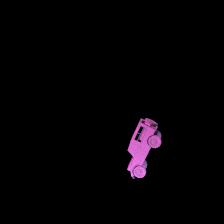

In [73]:
image

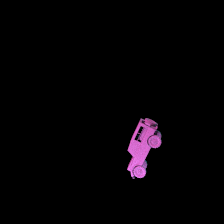

In [74]:
Image.open(impath)

In [75]:
# def render_from_random_indo(info, key):
#     category, instance, random_key = key.split('_')
#     all_light_positions, random_reflectance, camera_position, light_intensities = info[key]
    
#     all_light_positions = get_light_positions(MAX_NUM_LIGHTS, RADIUS_MIN, RADIUS_MAX)
#     random_reflectance = get_random_reflectance()
#     camera_position = get_light_positions(1, RADIUS_MIN_CAM, RADIUS_MAX_CAM)[0]
    
    
#     obj_model_all = pyredner.load_obj(obj_path, return_objects=True)
#     obj_model = [i for i in obj_model_all if len(i.vertices)>0]
#     m = pyredner.Material(specular_reflectance = random_reflectance, two_sided = True)
#     for part in obj_model:
#         part.material = m
    
#     scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224))
#     scene_cam.position = camera_position
    
#     scene_lights = []
#     light_intensities = []
#     for light_pos in all_light_positions:
#         light_intensity = get_random_intensity()
#         scene_light = pyredner.generate_quad_light(position = light_pos,
#                                          look_at = torch.zeros(3),
#                                          size = torch.tensor([0.5, 0.5]),
#                                          intensity = light_intensity,
#                                          directly_visible = False)
#         light_intensities.append(light_intensity)
#         scene_lights.append(scene_light)
#     all_objects = obj_model + scene_lights
#     scene = pyredner.Scene(objects = all_objects, camera = scene_cam)
#     img = pyredner.render_pathtracing(scene,num_samples=256,seed=1)
#     im = torch.pow(img.data, 1.0/2.2).cpu()
#     im = im*255/torch.max(im)
    
#     image = Image.fromarray(im.numpy().astype('uint8'))
    
#     cat_key = model_file.split('/')[-4]
#     inst_key = model_file.split('/')[-3]
#     random_key = x = ''.join(random.choices(string.ascii_letters + string.digits, k=16))
    
#     image_key = "%s_%s_%s"%(cat_key, inst_key, random_key)
#     random_info = [all_light_positions, random_reflectance, camera_position, light_intensities]
    
#     return image, image_key, random_info




# with open(model_files_pickle_path, 'rb') as F:
#     model_files = pickle.load(F)


# RANDOMIZED_INFORMATION_CATEGORY = {}
# total = 0
# category = CATEGORY
# category_dir = "%s/%s"%(SHAPENET_DIR, category)
# category_path = "%s/%s"%(dataset_path, category)
# create_folder(category_path)
# images_folder = "%s/images"%category_path
# create_folder(images_folder)
# instance_model_files = model_files[category]
# for model_file in instance_model_files:
#     model_file = model_file.replace('/om5/user/smadan',user_root_dir)
#     instance = model_file.split('/')[-3]
#     for repeat in range(1000):
#         rendered_im, im_name, random_info = render_shapenet_obj(model_file)
#         RANDOMIZED_INFORMATION_CATEGORY[im_name] = random_info
#         image_path = "%s/%s.png"%(images_folder, im_name)
#         rendered_im.save(image_path)
#         if total % 10 == 0:
#             with open('%s/randomized_info_%s.p'%(category_path, category),'wb') as F:
#                 pickle.dump(RANDOMIZED_INFORMATION_CATEGORY, F)
#         total += 1